In [25]:
import json
from types import *
from dataloader import *
from util import *
from graphs import *
from agreement import *

data = []

# Load David's preliminary data
# with open('../preliminary/david-first-eighty.json') as f:
#     data += json.load(f)

# Load tutorial feedback
# for filename in os.listdir('../tutorial/'):
#     with open('../tutorial/' + filename) as f:
#         individual_annotation = json.load(f)
#         for entry in individual_annotation:
#             entry['user'] = filename.split('.')[0]
#         data += individual_annotation

# Load batch 1 data
batch_num = 1
files = [x for x in os.listdir('../annotated/') if x.startswith('batch_' + str(batch_num))]
files = [x for x in files if 'rachel' not in x]
for filename in files:
    with open('../annotated/' + filename) as f:
        individual_annotation = json.load(f)
        
        for entry in individual_annotation:
            entry['user'] = filename.split('.')[0].split('_')[-1]
        data += individual_annotation

data = consolidate_edits(data)          # Adds 'edits' field
data = consolidate_annotations(data)    # Adds 'processed_annotations' field

Couldn't process grammar for annotation: ['positive', 'somewhat', '', '']


In [26]:
# Print spans with comments
get_comments(data)

VISHNESH - HIT 3: No simplifications

VISHNESH - HIT 7: 
VISHNESH - HIT 10: Was not able to select split edit as a structure edit.
VISHNESH - HIT 13: No simplification
VISHNESH - HIT 21: Fluency seems a bit off.
Something like "but did not have details" would be better.
VISHNESH - HIT 22: Deleting this makes it look like a trial itself had not been determined which kind of contradicts the first part of the sentence.
VISHNESH - HIT 30: No simplification
VISHNESH - HIT 36: collapsed was substituted as collaped. Not sure why this typo arose but I labelled it a grammatical error.

Marked the structural change as a bad one because it sounds incorrect to say "she suffered from a tonsillar cyst" compared to "she had a tonsillar cyst"
VISHNESH - HIT 43: No simplification
VISHNESH - HIT 44: I think that complex and building are not interchangeable so I marked it as a bad substitution. Building complexes usually refer to a much larger group of buildings.


In [27]:
# The systems we looked at
systems = set([x['system'] for x in data])

# Edit types
edit_types = set(data[0]['annotations'].keys())

In [28]:
# Example: Searches for coreference errors
deletions = [process_annotation(k) for k in [i for j in [[x for x in sent['edits'] if x['type'] == 'deletion'] for sent in data] for i in j]]
for d in deletions:
    if d['error_type'] == Error.COREFERENCE:
        print(d)

{'edit_type': 'deletion', 'id': 0, 'information_impact': <Information.LESS: 'Less Information'>, 'type': <Quality.ERROR: 'Error'>, 'grammar_error': True, 'error_type': <Error.COREFERENCE: 'Coreference'>, 'rating': 1, 'size': 25}


In [29]:
# Example: Annotations for sentence 0
data[0]['processed_annotations']

[{'edit_type': 'substitution',
  'id': 0,
  'information_impact': <Information.SAME: 'Same Information'>,
  'type': <Quality.QUALITY: 'No Error'>,
  'grammar_error': False,
  'error_type': None,
  'rating': 1,
  'size': 0.20535714285714285,
  'score': -0.20535714285714285}]

In [30]:
# Example: Edits for sentence 0
data[0]['edits']

[{'type': 'substitution',
  'id': 0,
  'original_span': (46, 73),
  'simplified_span': (46, 50),
  'annotation': ['same', 'positive', 'somewhat', '', 'no']}]

In [31]:
# Example: Agreement between annotators on edit types
# for edit_type in ['deletion', 'insertion', 'reorder', 'substitution']:
#     print(f'{edit_type} -> {calculate_agreement(data, edit_type, drop_no_spans=True)}')

In [32]:
# TODO: trivial edits on substitutions aren't being processed correctly
# for sent in data:
#     for ann in sent['processed_annotations']:
#         if ann['type'] == Quality.TRIVIAL and ann['rating'] == None:
#             print(sent['id'])
#             print(ann)
#             print(sent['system'])
#             print(sent['system'])
#             print(sent['user'])

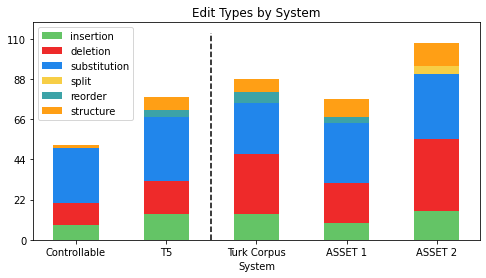

In [33]:
edit_type_by_system(data, flipped=True)

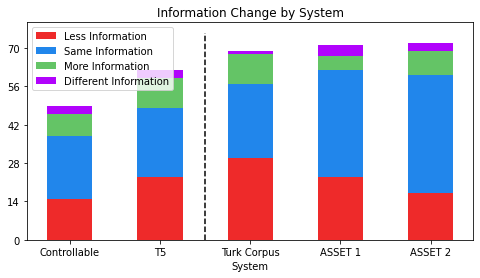

In [34]:
system_by_information_change(data)

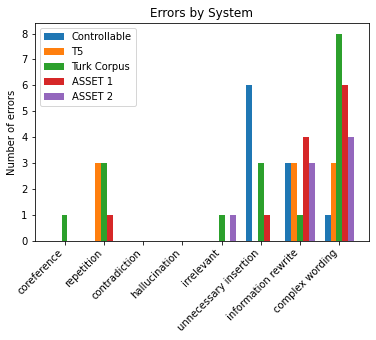

In [35]:
errors_by_system(data)

In [36]:
sankey_seperated(data)

In [37]:
sankey_combined(data)

In [38]:
# Prints the sentences where annotators identified errors
for error in [Error.REPETITION, Error.CONTRADICTION, Error.HALLUCINATION, Error.IRRELEVANT]:
    print(error.value)
    for sent in data:
        for ann in sent['processed_annotations']:
            if ann['error_type'] == error:
                print(f'HIT {sent["id"]+1} \t {sent["user"]} \t {system_name_mapping[sent["system"]]}')
    print()

Repetition
HIT 8 	 vinayak 	 T5
HIT 8 	 vinayak 	 T5
HIT 10 	 vinayak 	 Turk Corpus
HIT 10 	 vinayak 	 Turk Corpus
HIT 10 	 vinayak 	 Turk Corpus
HIT 18 	 vinayak 	 T5
HIT 19 	 vinayak 	 ASSET 1

Contradiction

Hallucination

Irrelevant
HIT 10 	 vinayak 	 Turk Corpus
HIT 25 	 vinayak 	 ASSET 2



In [39]:
# Print the avg. sentence scores for each system
def avg(lst):
    return round(sum(lst) / len(lst), 2)

for s in systems:
    print(f'{system_name_mapping[s]} \t {avg([sent["score"] for sent in data if sent["system"] == s])}')

Turk Corpus 	 -0.1
Controllable 	 -0.05
ASSET 2 	 -0.06
ASSET 1 	 -0.05
T5 	 -0.07


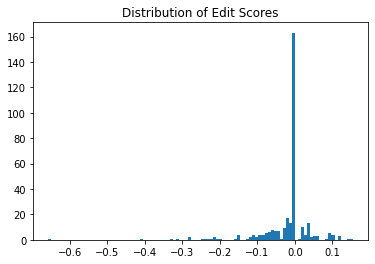

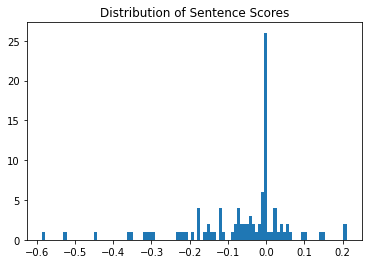

In [40]:
import warnings
warnings.filterwarnings("ignore")

# Annotation scores
annotations = sorted([x for y in [sent['processed_annotations'] for sent in data] for x in y], key=lambda x: x['score'])

# Print distribution of edit scores
n_bins = 100
fig, axs = plt.subplots(1)
axs.hist([x['score'] for x in annotations], bins=n_bins)
axs.set_title("Distribution of Edit Scores")
fig.show()

# Print distribution of edit scores
n_bins = 100
fig, axs = plt.subplots(1)
axs.hist([x['score'] for x in data], bins=n_bins)
axs.set_title("Distribution of Sentence Scores")
fig.show()

In [41]:
# Calculate the inter-annotator agreement on sentence-level scores
for sent_id in range(0, 50):
    sents = [x for x in data if x['id'] == sent_id]
    scores = [x['score'] for x in sents]
    # print(scores)

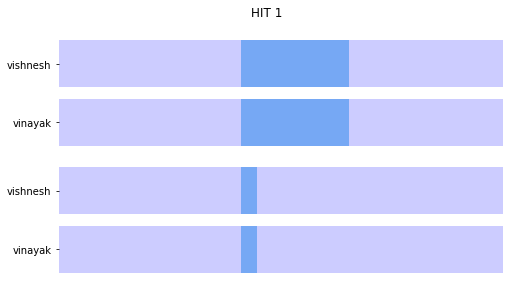

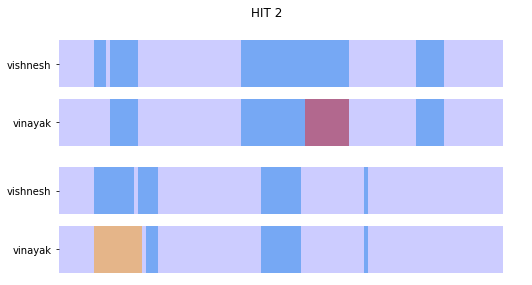

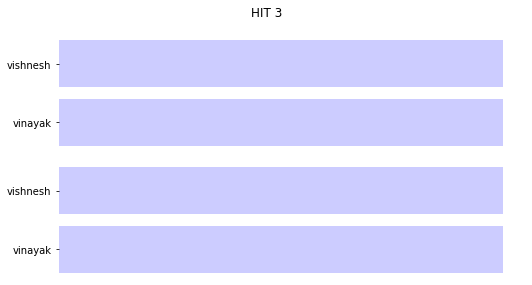

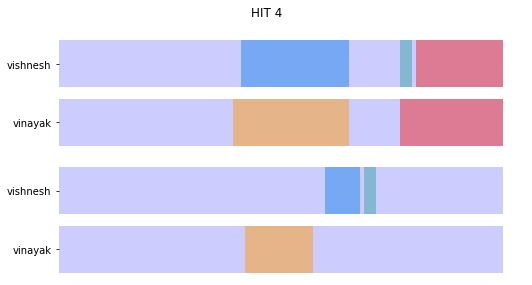

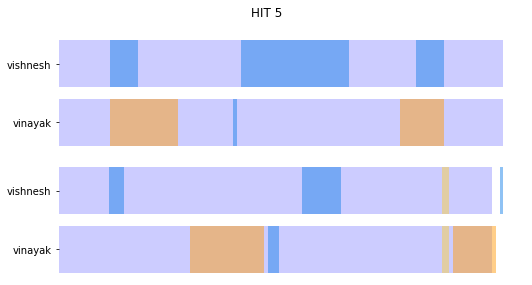

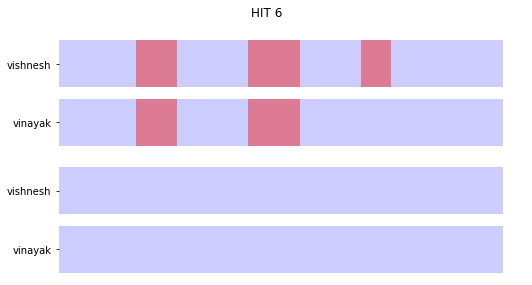

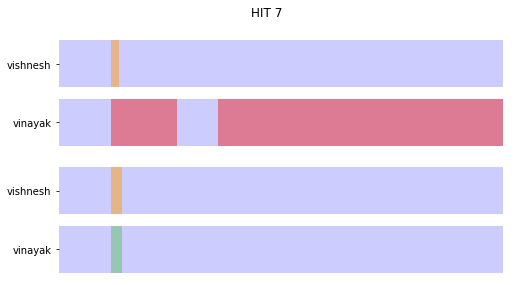

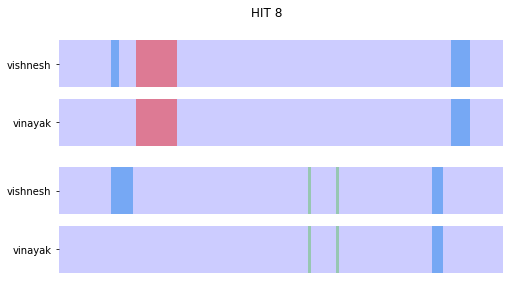

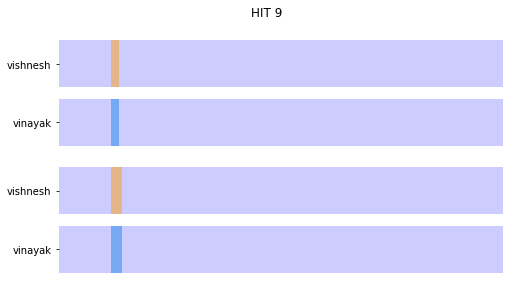

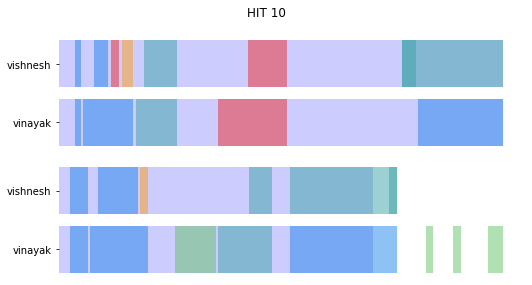

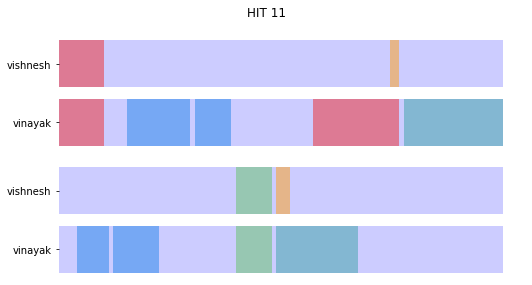

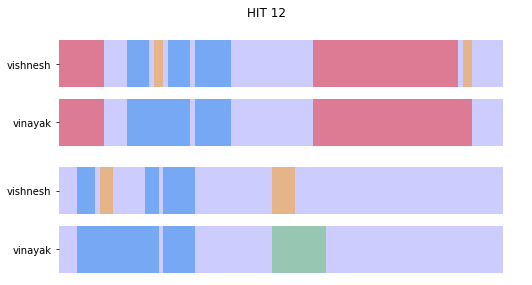

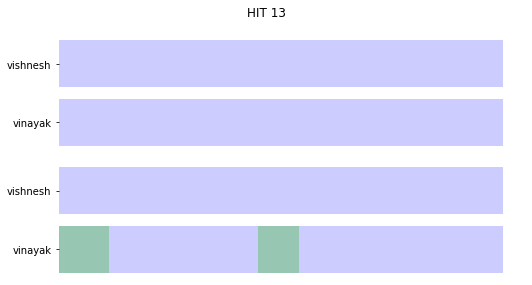

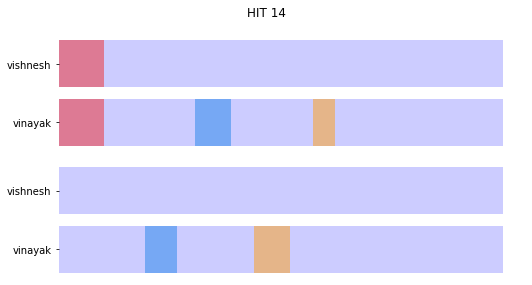

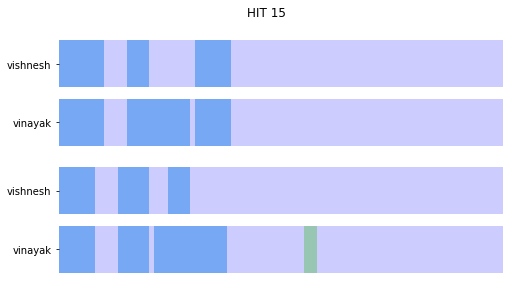

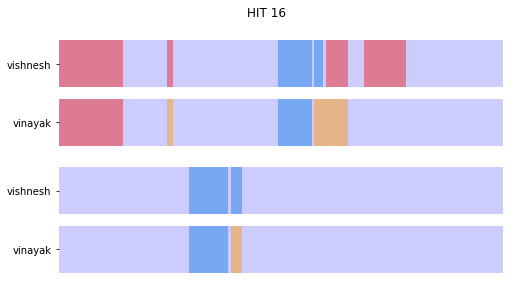

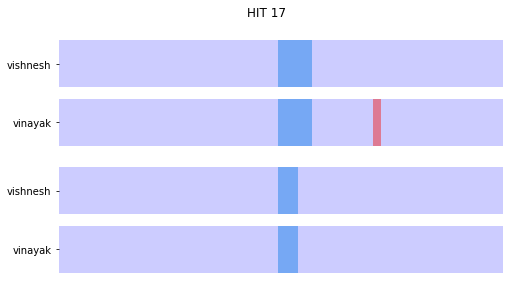

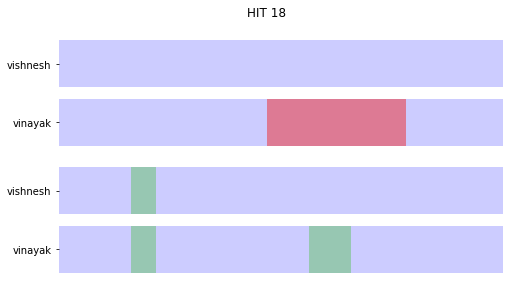

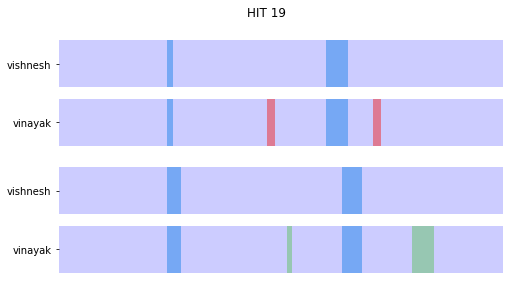

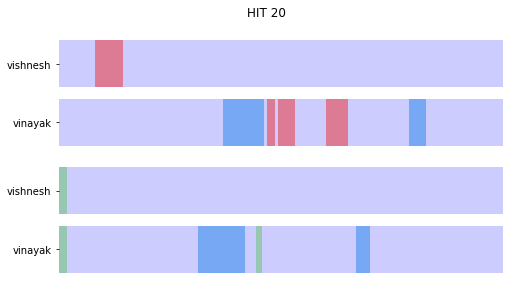

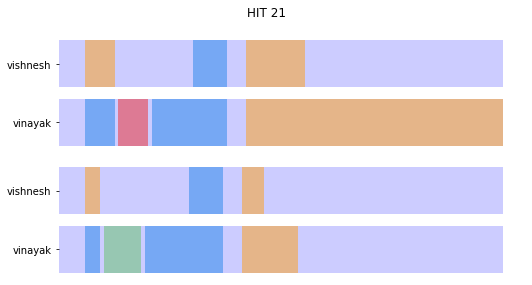

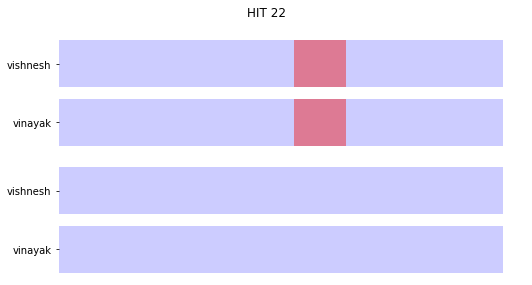

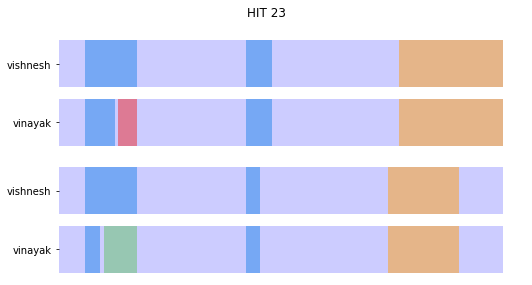

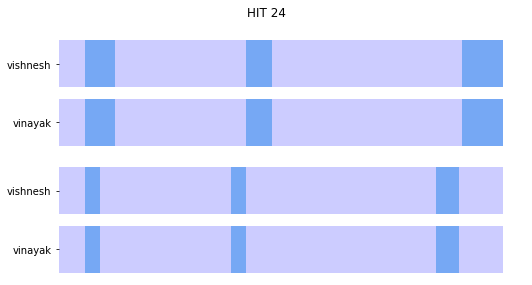

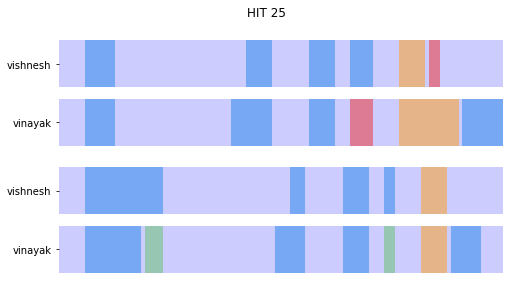

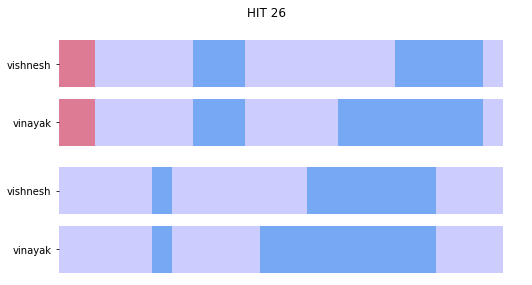

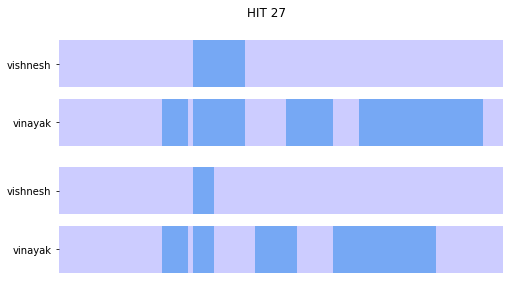

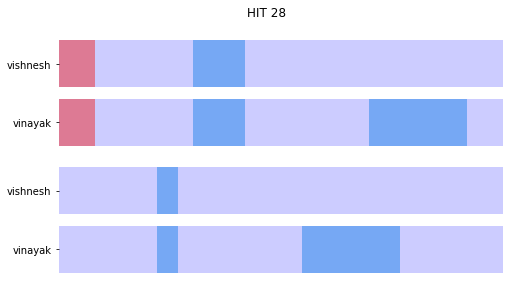

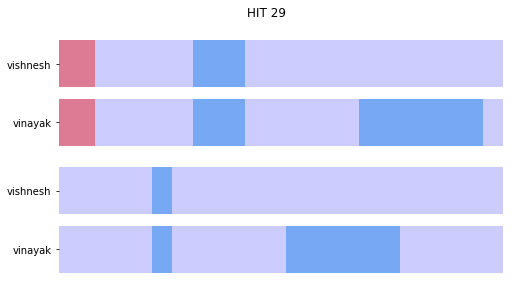

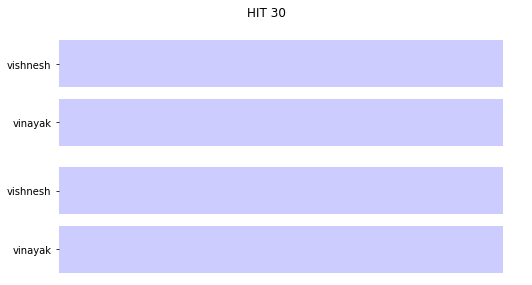

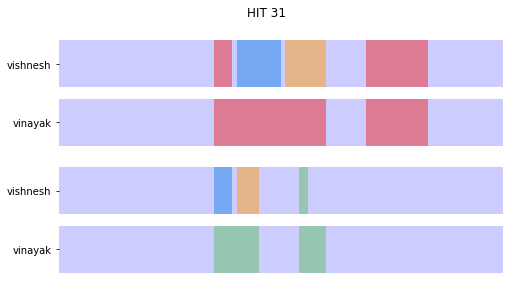

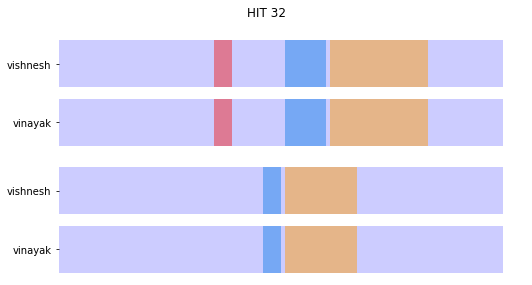

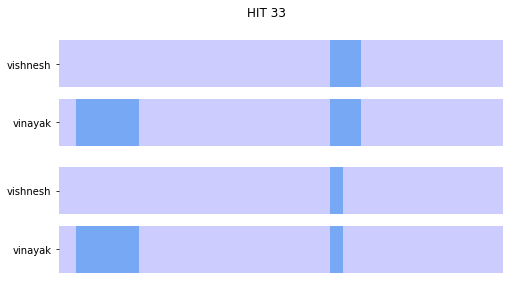

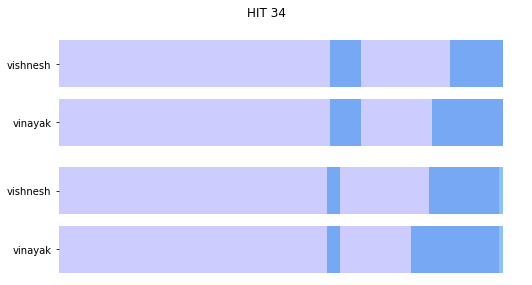

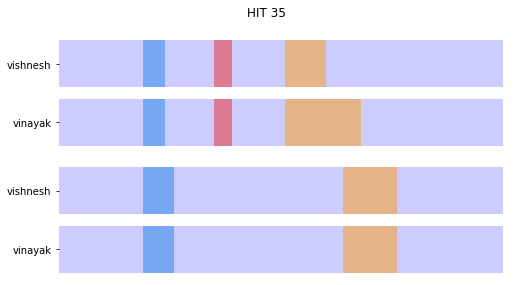

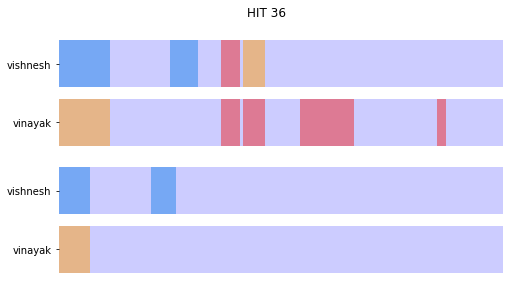

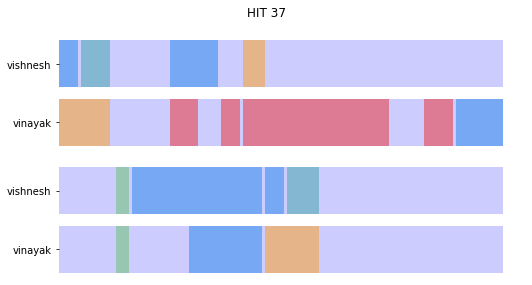

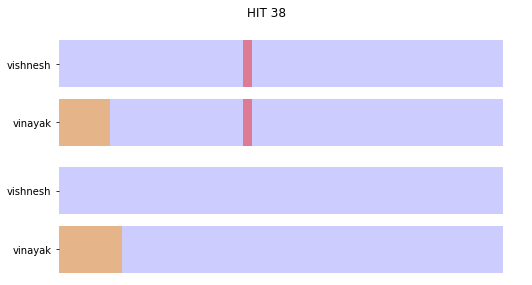

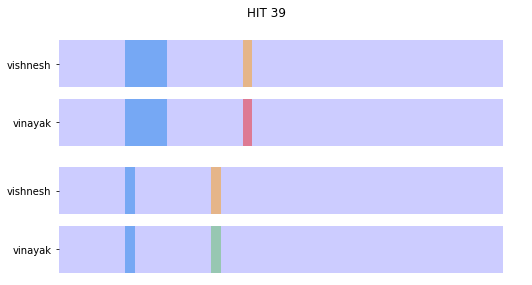

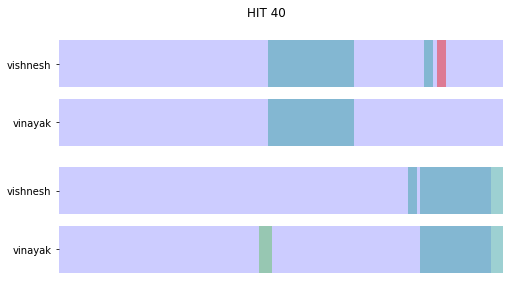

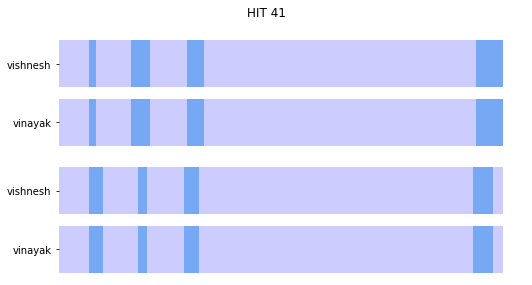

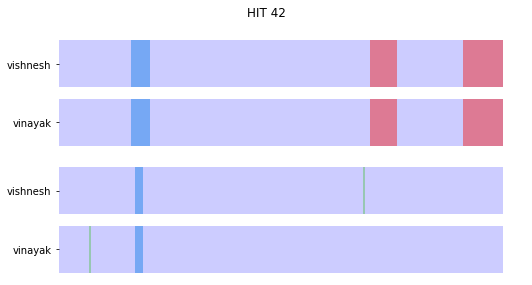

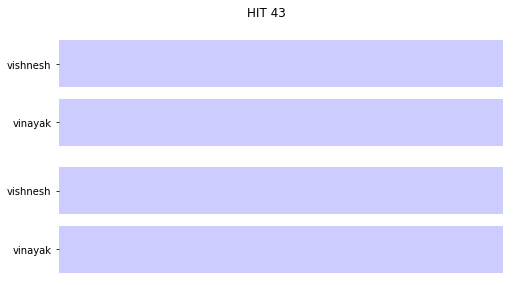

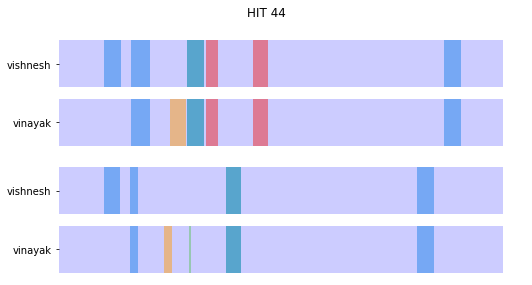

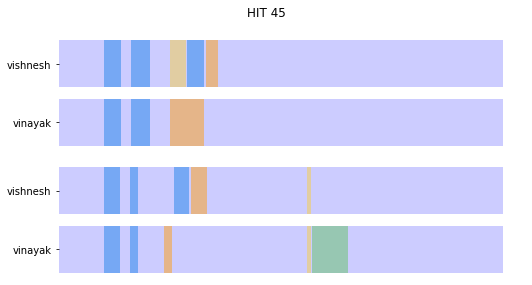

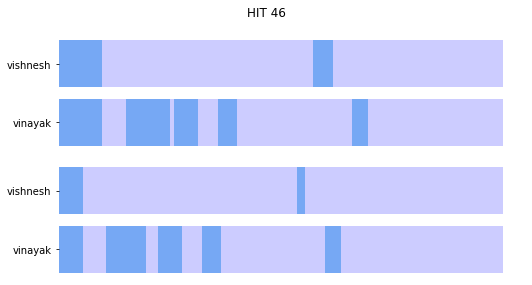

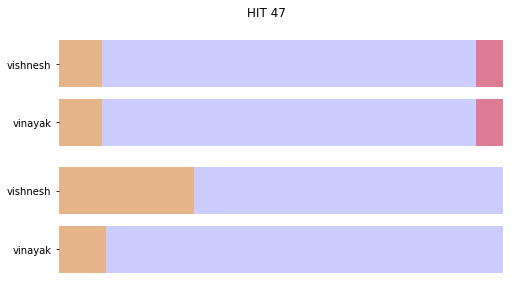

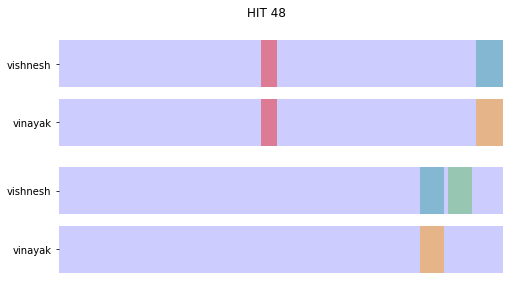

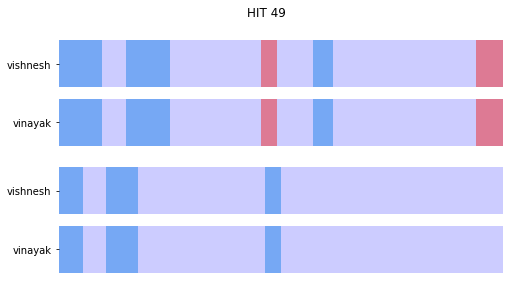

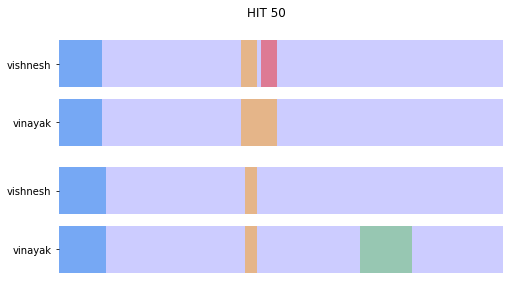

In [44]:
plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.max_open_warning"] = False

MAX_HIT = 50

for sent_id in range(0, MAX_HIT):
    fig, ax = plt.subplots(2)

    sents = [x for x in data if x['id'] == sent_id]
    annotator = list(set([x['user'] for x in sents]))
    sent_spans = [len(sents[0]['original']) for i in sents]
    

    for axis_num, sent_type in enumerate(['original_span', 'simplified_span']):
        b1 = ax[axis_num].barh(annotator, sent_spans, color="blue", alpha=0.2)

        for edit_type in edit_types:
            entry = []
            for edit_number in range(max([len([x for x in sent['edits'] if x['type'] == edit_type]) for sent in sents])):
                e = []
                for i in range(len(sents)):
                    edits = [x for x in sents[i]['edits'] if x['type'] == edit_type]
                    if edit_number < len(edits) and edits[edit_number][sent_type] is not None:
                        e.append(edits[edit_number][sent_type])
                    else:
                        e.append((0, 0))
                entry.append(e)
            
            for e in entry:
                b2 = ax[axis_num].barh(annotator, [x[1]-x[0] for x in e], left=[x[0] for x in e], color=color_mapping[edit_type], alpha=0.5)

        ax[axis_num].set_xticks([])

        ax[axis_num].spines['bottom'].set_visible(False)
        ax[axis_num].spines['top'].set_visible(False)
        ax[axis_num].spines['left'].set_visible(False)
        ax[axis_num].spines['right'].set_visible(False)
    
    # plt.legend([b1, b2], ["None", "Deletion", "Substitution"], title="Edit Type", loc="upper right")
    fig.suptitle(f'HIT {sent_id+1}')

    fig.show()